In [2]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from src.embedding import Embedding
from src.environment import Rewards_env
from src.evaluations import evaluate, plot_eva
from src.regression import *
from src.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/ownCloud/git/Solaris/synbio_rbs/demo
['/home/admin-u6015325/ownCloud/git/Solaris/synbio_rbs/demo', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles/vscode_datascience_helpers', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/Solaris/synbio_rbs']


# Plot setting

In [3]:
font_size = 15

rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 13
rcParams['axes.titlesize'] = 15
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Computer Modern Roman']
# rcParams['text.usetex'] = True

# set color
# https://www.thinkingondata.com/something-about-viridis-library/
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

color_dict['Consensus'] = tab10.colors[0]
color_dict['Reference'] = tab10.colors[6]
color_dict['BPS-C'] = tab10.colors[14]
color_dict['BPS-NC'] = tab10.colors[12]
color_dict['UNI'] = tab10.colors[10]
color_dict['PPM'] = tab10.colors[11]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

color_dict['Bandit-0'] = viridis.colors[3]
color_dict['Bandit-1'] = viridis.colors[8]
color_dict['Bandit-2'] = viridis.colors[13]
color_dict['Bandit-3'] = viridis.colors[18]

color_dict['Unlabeled'] = tab10.colors[15]
color_dict['Random'] = tab10.colors[10]

bandit_color_dict = {}

bandit_color_dict['Bandit-0'] = viridis.colors[3]
bandit_color_dict['Bandit-1'] = viridis.colors[8]
bandit_color_dict['Bandit-2'] = viridis.colors[13]
bandit_color_dict['Bandit-3'] = viridis.colors[18]

# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')

folder_path = '../data/'
# plot_path = '../../notebooks/paper_plots/'
plot_path = '../../paper/plots/Main_Paper/'
plot_path_supp = '../../paper/plots/Supplementary/'

# plot_path = '../../../paper/writing/wcb_icml2021/wcb2021_plot/'

In [4]:
plot_swarm_flag = True
plot_quant_flag = True
plot_scatter_flag = True
plot_tsne_flag = True
plot_hist_flag = True
gene_rec_flag = False

In [5]:
wcb_color_dict = {}

viridis = cm.get_cmap('viridis', 20)
tab10 = cm.get_cmap('tab20', 20)

wcb_color_dict['Consensus'] = tab10.colors[0]
wcb_color_dict['Reference'] = tab10.colors[6]
wcb_color_dict['Random'] = tab10.colors[10]

# color_dict['Bandit-0'] = viridis.colors[0]
# color_dict['Bandit-1'] = viridis.colors[1]
# color_dict['Bandit-2'] = viridis.colors[2]
# color_dict['Bandit-3'] = viridis.colors[3]

wcb_color_dict['Bandit-0'] = viridis.colors[3]
wcb_color_dict['Bandit-1'] = viridis.colors[8]
wcb_color_dict['Bandit-2'] = viridis.colors[13]
wcb_color_dict['Bandit-3'] = viridis.colors[18]
wcb_color_dict['Unlabeled'] = tab10.colors[15]


# Read data

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
    - C.2 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on each round
    - D.2 on all data
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 
    - E.1 on each round
    - E.2 on all data

In [6]:
# read data

df_n = pd.read_csv(folder_path + 'Results_n.csv') # raw data
df_e1 = pd.read_csv(folder_path + 'Results_e1.csv')
df_abc2 = pd.read_csv(folder_path + 'Results_abc2.csv')
df_abc1 = pd.read_csv(folder_path + 'Results_abc1.csv')
df_bc1 = pd.read_csv(folder_path + 'Results_bc1.csv')
df_TOP30 = pd.read_excel(folder_path + "Plots.xlsx", sheet_name = "TOP30")
df_ALL = pd.read_excel(folder_path + "Plots.xlsx", sheet_name = "All")
df_Pos = pd.read_csv(folder_path + 'Pos_Change.csv') 
df_SD = pd.read_excel(folder_path + "Plots.xlsx", sheet_name = "SD")

In [7]:
df_e1['Group2'] = df_e1['Group']
df_e1.loc[df_e1['Group2'] == 'UNI', 'Group2'] = 'Random'
df_e1.loc[df_e1['Group2'] == 'PPM', 'Group2'] = 'Random'

# Scatterplot

In [8]:
# copy from the pipeline for recommending round 2 seq
from src.batch_ucb import *
from src.regression import *
from scipy.stats import spearmanr

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

sns.set_palette('tab10') 

In [9]:
def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
                    eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
                    eva_on='seqs', title = 'Prediction',
                    kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True, kernel_over_all_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression(random_state = 0)

    return gpr_train_samples
    # gpr_train_samples.scatter_plot(title = title)

In [10]:
def scatter_plot(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        fig, axes = plt.subplots(2,2, figsize = (12,12))
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            if i < 2:
                row = 0
            else:
                row = 1

            axes[row, i % 2].scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes[row, i % 2].scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes[row, i % 2].set_xlabel('True TIR')
            axes[row, i % 2].set_ylabel('Predict TIR')
            axes[row, i % 2].legend()
            axes[row, i % 2].plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes[row, i % 2].set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
#         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path + 'scatter_' + valid_path(plot_title) + '.pdf')

In [11]:
def scatter_plot_single(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        # fig, axes = plt.subplots(1,4, figsize = (20,6))
        sns.set_palette('tab10') 
        
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            fig, axes = plt.subplots(1,1, figsize = (6,6))

            axes.scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes.scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes.set_xlabel('True TIR')
            axes.set_ylabel('Predict TIR')
            axes.legend()
            axes.plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes.set_title('\n' + title[i] + 
                '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

#           fig.suptitle(plot_title, size = 16, y = 0.98)
            fig.tight_layout()
    #       fig.subplots_adjust(top=0.85)
            fig.savefig(plot_path_supp + 'scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')

In [13]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False

    df_abc1_FF_predictors = generate_predictors(df_abc1, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (89, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (93, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Loa

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7f15fdd5a488>
Train:  0.28350109011840735
Test:  0.8403252988267403
<function r2_score at 0x7f15fdd5a6a8>
Train:  0.6723153226798286
Test:  0.06693910443048467
spearman cor:
Train:  SpearmanrResult(correlation=0.8463617235506963, pvalue=2.3476913055622297e-290)
Test:  0.26886278515492   0.010844003382253626
Test pred fit:  [0.00180472 0.0168697 ]
Test ave fit:  [ 0.03619848 -1.59273318]
coverage rate: 
Train:  0.7668246445497631
Test:  0.5955056179775281
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7f15fdd5a488>
Train:  0.378004989211352
Test:  0.7034740004065209
<function r2_score at 0x7f15fdd5a6a8>
Train:  0.5690171732617391
Test:  0.22587011585029304
spearman cor:
Train:  SpearmanrResult(correlation=0.7719917802404416, pvalue=1.264362013e-3

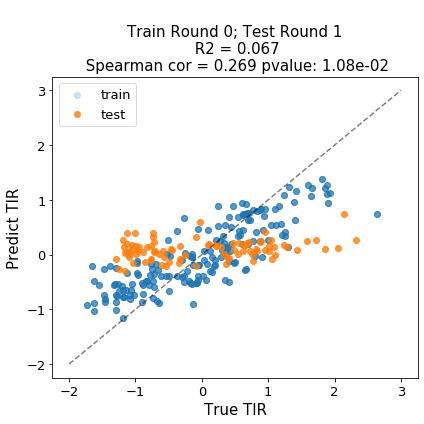

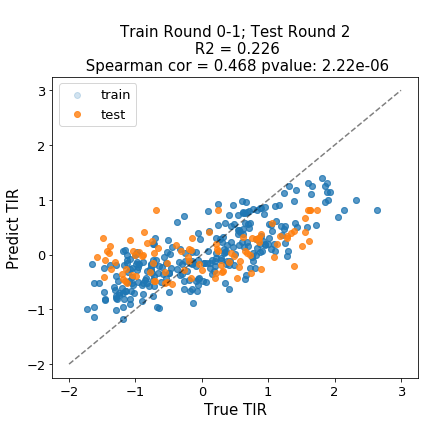

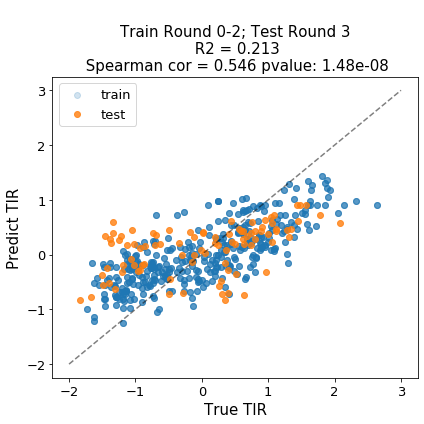

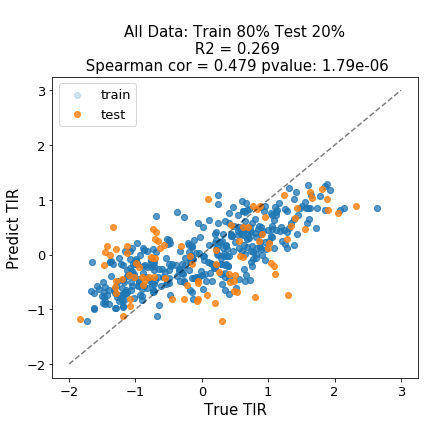

In [14]:
if plot_scatter_flag:
    
    scatter_plot_single(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF')

# Exploration v.s. Exploitation  

In [16]:
# projection 

# p1 = np.asarray([0,1])
# p2 = np.asarray([1,0])
# p3 = np.asarray([1,1])

def proj(to_proj_list, p1 = np.asarray([0,1]), p2 = np.asarray([1,0])):
    projections = []
    l2 = np.sum((p1-p2)**2)

    for p3 in to_proj_list:
#         t = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
        t = np.sum((p3 - p1) * (p2 - p1)) / l2
        projection = p1 + t * (p2 - p1)

        projections.append(projection)
    
    return np.asarray(projections)

def mean_vs_var_plot(predictor_list, title, plot_title = 'Prediction'):
    """Scatter plot for predictions.
    x-axis: label
    y-axis: prediction
    """
    # fig, axes = plt.subplots(1,4, figsize = (20,6))
    
    proj_df_list = []
    for i, predictor in enumerate(predictor_list[:3]):


        if i < 2:
            row = 0
        else:
            row = 1

        projections = proj(np.asarray(predictor.test_df[['pred mean', 'pred std']]))
        print(i)
        print('Round: ', predictor.test_df['Round'].unique())
        test_df = predictor.test_df.copy()
        test_df['proj0'] = projections[:,0]
        proj_df_list.append(test_df)

#             axes[row, i % 2].scatter(predictor.train_df['pred mean'], predictor.train_df['pred std'], label = 'train', alpha = 0.2)
        
        fig, axes = plt.subplots(1,1, figsize = (6,6))
        axes.scatter(predictor.test_df['pred mean'], predictor.test_df['pred std'], label = 'test', alpha = 0.8, color = tab10.colors[2])
        sns.set_palette('RdBu') 
        axes.scatter(projections[:,0], projections[:,1], label = 'projections', c = projections[:,0], cmap = 'RdBu')
        axes.set_ylabel('Predict STD')
        axes.set_xlabel('Predict TIR')
        axes.legend()
        axes.plot([0, 1], [1,0], '--', color = 'black', alpha = 0.5)
        axes.set_title('\n' + title[i]                  
#                  + '\n R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
#                 '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
            )
        axes.set_xlim(-1,1.5)   
        axes.set_ylim(-1,1.5) 
#         fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
    #         fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path_supp + 'proj_scatter_' + valid_path(plot_title) + '_' + str(i) + '.pdf')
    return proj_df_list

0
Round:  [1]
1
Round:  [2]
2
Round:  [3]


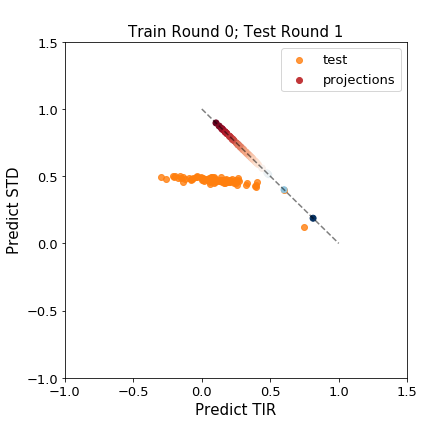

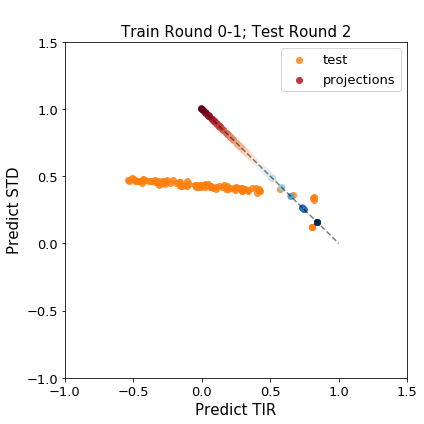

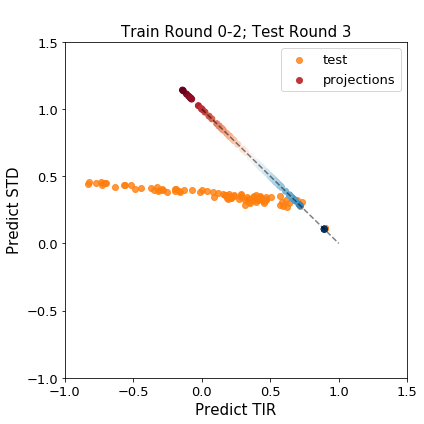

In [17]:
sns.set_palette('tab10') 
proj_df_list = mean_vs_var_plot(df_abc1_FF_predictors, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF')

In [61]:
len(df_abc1_proj[(df_abc1_proj['Round'] == 3) & (df_abc1_proj['proj0'] >= 0.5)])

37

In [43]:
proj_df = pd.concat(proj_df_list)[['proj0']]
# [['Name', 'RBS', 'proj0']]
df_abc1_proj = df_abc1.merge(proj_df, how = 'left', left_index=True, right_index=True)

In [57]:
df_abc1_proj

,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD,proj0
0,RBS_1by1_0,Reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,0.334474,NaN
1,RBS_1by1_1,BPS-NC,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,0.279010,NaN
2,RBS_1by1_2,BPS-NC,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,0.187660,NaN
3,RBS_1by1_3,BPS-NC,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,0.226911,NaN
4,RBS_1by1_4,BPS-NC,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,0.306855,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,RBS_BA4_16,Bandit-3,Fifth_Plate,3,TTTAAGAAAACAATATACAT,AAACAA,0.400552,0.312127,0.348311,0.288340,0.251619,0.478993,0.346657,0.082517,-0.140862
447,RBS_BA4_502,Bandit-3,Fifth_Plate,3,TTTAAGAACTTCGTATACAT,ACTTCG,0.488621,0.350810,0.342482,0.292763,0.272788,0.087671,0.305856,0.130870,-0.082285
448,RBS_1by1_0,Reference,Fifth_Plate,3,TTTAAGAAGGAGATATACAT,AGGAGA,1.243620,1.474236,1.438197,1.562669,1.542206,1.635187,1.482686,0.135941,0.894087
449,RBS_1by1_0,Reference,Fifth_Plate,3,TTTAAGAAGGAGATATACAT,AGGAGA,1.536933,1.620994,1.579009,1.455546,1.508739,1.717542,1.569794,0.092083,0.894087


In [72]:
def generate_predictors(df, kernel, embedding, kernel_norm_flag = True, centering_flag = True, unit_norm_flag = True, kernel_over_all_flag = True, df_proj=None):
    predictors = []

    if df_proj is not None:
        df_test = df_proj.copy()
    else:
        df_test = df.copy()
        
    for i in range(1,4):
        title = 'Train < ' + str(i)+ ' and Test ' + str(i)
        predictor = run_regression(df, kernel, embedding, train_idx = df['Round'] < i, test_idx = (df_test['Round'] == i) & (df_test['proj0'] >= 0.4), title = title, centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
        predictors.append(predictor)

    predictor = run_regression(df, kernel, embedding, title = 'Train and Test on All Rounds', centering_flag=centering_flag, unit_norm_flag=unit_norm_flag, kernel_over_all_flag = kernel_over_all_flag)
    predictors.append(predictor)
    return predictors
    

In [73]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False

    df_abc1_FF_predictors_expoit = generate_predictors(df_abc1_proj, kernel, embedding, kernel_norm_flag = True, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag)

X train shape:  (1055, 20)
X test shape:  (11, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (1589, 20)
X test shape:  (28, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
gp_reg pred
finish reg
X train shape:  (2147, 20)
X test shape:  (57, 20)
create kernel instance
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
finish creating kernel instance
gp_reg fit
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_False
Loa

#################################
  Evaluation   Train Round 0; Test Round 1
#################################
<function mean_squared_error at 0x7f15fdd5a488>
Train:  0.28350109011840735
Test:  1.59212719294906
<function r2_score at 0x7f15fdd5a6a8>
Train:  0.6723153226798286
Test:  0.011921818089161484
spearman cor:
Train:  SpearmanrResult(correlation=0.8463617235506963, pvalue=2.3476913055622297e-290)
Test:  0.09090909090909091   0.7903727377532903
Test pred fit:  [0.01199916 0.33748368]
Test ave fit:  [ 0.38555235 -1.73619213]
coverage rate: 
Train:  0.7668246445497631
Test:  0.2727272727272727
#################################
  Evaluation   Train Round 0-1; Test Round 2
#################################
<function mean_squared_error at 0x7f15fdd5a488>
Train:  0.378004989211352
Test:  0.8503501438209392
<function r2_score at 0x7f15fdd5a6a8>
Train:  0.5690171732617391
Test:  -0.005109908011771358
spearman cor:
Train:  SpearmanrResult(correlation=0.7719917802404416, pvalue=1.264362013e

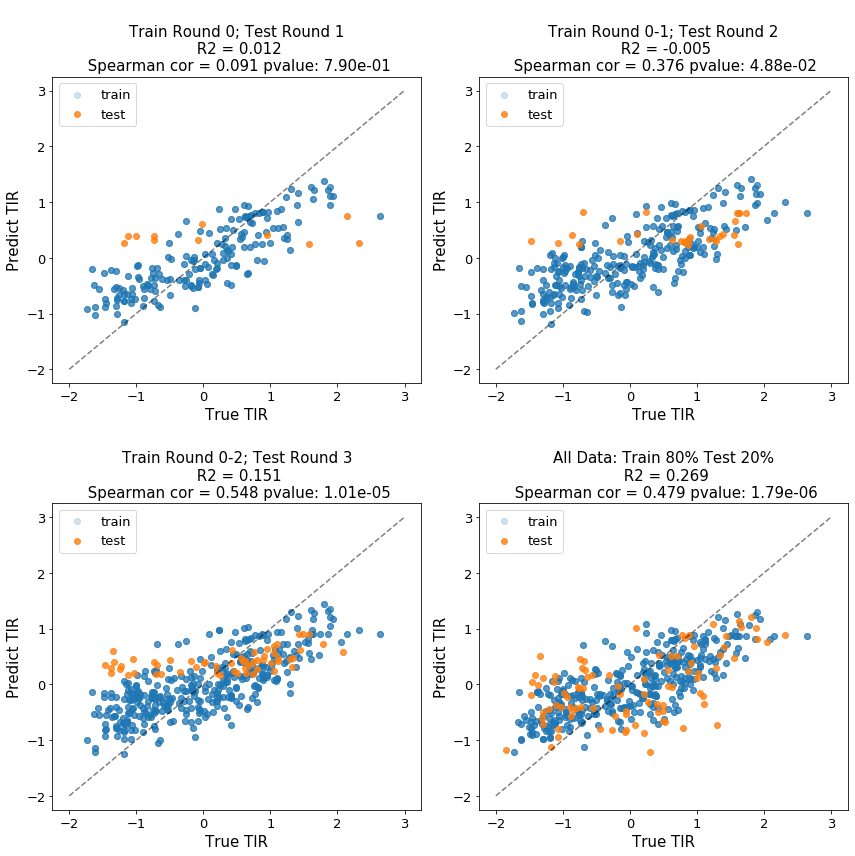

In [74]:
if plot_scatter_flag:
    
    scatter_plot(df_abc1_FF_predictors_expoit, 
                ['Train Round 0; Test Round 1', 'Train Round 0-1; Test Round 2', 'Train Round 0-2; Test Round 3', 'All Data: Train 80% Test 20%'], 'abc1 FF')

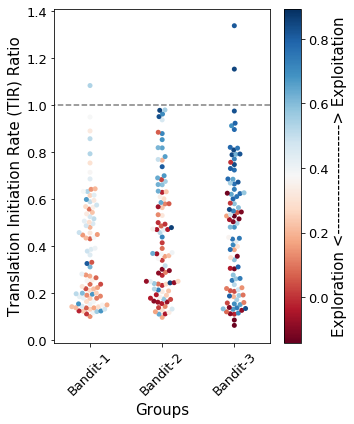

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib.colors
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

if plot_swarm_flag:
    fig, axes = plt.subplots(1, 1, figsize=(5, 6), sharex=False)
        
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1_proj, ax = axes, order=['Bandit-1', 'Bandit-2', 'Bandit-3'], hue = 'proj0', palette = 'RdBu')
#     sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1_proj, ax = axes, order=['Bandit-1', 'Bandit-2', 'Bandit-3'], hue = 'proj0', palette = colors)
    norm = plt.Normalize(df_e1_proj['proj0'].min(), df_e1_proj['proj0'].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])

    axes.get_legend().remove()
    cb = axes.figure.colorbar(sm)
    cb.set_label('Exploration <--------------------> Exploitation')
    #     y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
#     axes.scatter(x = 0, y = y, color = color_dict['Consensus'])
    axes.plot([-1,9], [1,1], '--', color = 'grey')
#     axes.text(0, y + 0.05, 'SD')
    axes.set(xlabel='Groups', ylabel='Translation Initiation Rate (TIR) Ratio')
#     axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.legend([],[], frameon=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path + 'swarmplot_proj.pdf')